In [2]:
from dataclasses import dataclass
import numpy as np
import hashlib
import periodictable
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import h5py
import json

import scipy.spatial
import pickle
from tqdm import tqdm  # Import tqdm for progress bars

from ASF import ASF, Hyperparams
import result_types

def folder_name():
    return "/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/"

def file_name():
    rank = get_worker().id
    return folder_name() + f"rank_{rank:04}.hdf5"

def clear_cache():
    shutil.rmtree(folder_name(), ignore_errors=True)

def save_to_hdf5(asf, result):
    with lock:
        os.makedirs(folder_name(), exist_ok=True)
        with h5py.File(file_name(), "a") as f:
            if "hyperparams" not in f:
                f["hyperparams"] = json.dumps(dataclasses.asdict(asf.hyperparams))
            serializer = lambda asf: json.dumps({"num_electrons": 
                                                asf.num_electrons, "num_protons": 
                                                asf.num_protons, "excitations": list(asf.excitations)})
            group = f.create_group(type(result).__name__ + "/" + asf.get_uuid()  + 
                                ("_" + result.initial_asf.get_uuid() if result.initial_asf is not None else "") )
            group.attrs["asf"] = serializer(asf)
            for key, val in dataclasses.asdict(result).items():
                if type(val) == ASF:
                    val = serializer(val)
                if val is None:
                    val = "[None]"
                group[key] = val


class ResultsLoader:
    def __init__(self):
        self.file = folder_name() + "master.hdf5"
        self.file_handle = None
        print(self.file)

    def __enter__(self):
        if not os.path.exists(folder_name()):
            Warning("No results found.")
            return self
        worker_files = [file for file in os.listdir(folder_name()) 
                        if re.match("rank_.*.hdf5",  file)]
        if not worker_files:
            return self
        self.file_handle = h5py.File(self.file, "w")
        for file in worker_files:
            self.file_handle[file] = h5py.ExternalLink(folder_name()+file, "/") # why does this return None?
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self.file_handle is not None and self.file_handle:
            print("closing from __exit__")
            self.file_handle.close()

    def __del__(self):
        if self.file_handle is not None and self.file_handle:
            print("closing from __del__")

            self.file_handle.close()

    # Returns a generator of all calculated results as a tuple 
    #  (ASF, ConvergedResult, lambda())
    def get_all_runs(self):
        if self.file_handle is None:
            return
        for key, file in self.file_handle.items():
            hyperparams = Hyperparams(**json.loads(file["hyperparams"][()]))
            for convergence_type, con_group in file.items():
                if convergence_type == "hyperparams":
                    continue
                type = getattr(result_types, convergence_type)
                for run in con_group.values():
                    asf = ASF(**json.loads(run.attrs["asf"]), hyperparams=hyperparams)
                    yield asf, type, lambda run=run, hyperparams=hyperparams, type=type, filter=None,: ResultsLoader.deserialize_result(run, hyperparams, type, filter)
                    # yield asf, type, lambda filter=None: ResultsLoader.deserialize_result(run, hyperparams, type, filter)

    @staticmethod
    def deserialize_result(group, hyperparams, type, filter):
        fields = {}
        for key, val in group.items():
            if filter is not None and key not in filter:
                continue
            val = val[()]
            if type(val) == bytes:
                val = val.decode("utf-8")
            if key == "initial_asf":
                if val == b"[None]":
                    fields[key] = None
                else:
                    fields[key] = ASF(**json.loads(val), hyperparams=hyperparams)
            else:
                fields[key] = val
        return type(**fields)


In [209]:
# Original tuple
original_tuple = (1, 2, 3, 4)

# Create a frozenset from the tuple
fset = frozenset(original_tuple)

# Convert the frozenset back to a tuple
converted_tuple = tuple(fset)

print("Original tuple:", original_tuple)
print("Converted tuple:", converted_tuple)


Original tuple: (1, 2, 3, 4)
Converted tuple: (1, 2, 3, 4)


In [2]:
ion_keys_total = [(16, 13), (15, 14), (25, 22), (14, 11), (7, 7), (3, 3), (14, 13), (43, 40), (38, 35), (7, 5), (19, 16), (5, 4), (41, 39), (20, 18), (19, 17), (21, 19), (30, 27), (9, 9), (10, 10), (8, 8), (18, 16), (15, 15), (12, 10), (13, 10), (17, 16), (23, 21), (12, 9), (13, 13), (8, 6), (11, 9), (18, 15), (16, 15), (17, 17), (16, 14), (20, 19), (16, 16), (39, 36), (15, 13), (23, 20), (22, 21), (40, 39), (7, 6), (25, 23), (18, 18), (31, 29), (21, 21), (32, 30), (22, 22), (36, 33), (44, 44), (26, 25), (43, 42), (30, 28), (27, 26), (10, 9), (8, 7), (12, 12), (45, 44), (24, 23), (37, 34), (14, 12), (29, 29), (11, 10), (9, 7), (37, 35), (20, 17), (13, 11), (31, 28), (36, 35), (33, 30), (34, 31), (29, 28), (35, 34), (40, 40), (6, 5), (20, 20), (36, 36), (13, 12), (4, 3), (17, 15), (5, 5), (39, 37), (19, 18), (21, 18), (11, 8), (40, 38), (24, 21), (17, 14), (30, 29), (10, 7), (41, 40), (32, 29), (23, 22), (42, 39), (14, 14), (21, 20), (10, 8), (27, 24), (9, 6), (42, 40), (7, 4), (22, 20), (6, 3), (30, 30), (37, 36), (18, 17), (36, 34), (31, 30), (35, 32), (25, 24), (39, 38), (42, 41), (31, 31), (43, 41), (15, 12), (12, 11), (22, 19), (28, 25), (6, 6), (46, 43), (32, 31), (41, 38), (29, 27), (44, 42), (4, 4), (44, 41), (28, 26), (47, 44), (27, 25), (33, 31), (5, 3), (19, 19), (35, 33), (38, 36), (29, 26), (26, 23), (6, 4), (26, 24), (24, 22), (40, 37), (11, 11), (45, 42), (43, 43), (34, 34), (33, 32), (34, 33), (33, 33), (35, 35), (45, 43), (42, 42), (44, 43), (32, 32), (39, 39), (9, 8), (34, 32), (8, 5), (46, 44), (28, 27), (41, 41), (26, 26), (38, 37), (24, 24), (25, 25), (23, 23), (27, 27), (28, 28)]
ion_keys_sorted = sorted(ion_keys_total)
print(ion_keys_sorted[0:10])

[(3, 3), (4, 3), (4, 4), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6)]


In [4]:


ryd_to_kelvin = 11606 * 13.605703976
temp_kelvin = 5000

def process_result(added_index, tree, new_result, temp_kelvin=5000):
    remove_slice = slice(*new_result.slices[added_index])
    regularized = np.delete(new_result.eigenvectors, remove_slice, axis=1)
    dist, _ = tree.query(regularized)
    Ediff = new_result.eigenvalues - new_result.eigenvalues[0]  # ["Ryd."]
    bolzmann_factor = np.exp(-Ediff * ryd_to_kelvin / temp_kelvin)
    effect_output = (dist * bolzmann_factor).sum()
    return effect_output

def create_data_dict(ion_key_in, save_path='/Users/moustholmes/Projects/METAL-AI/data/ion_dicts_new/', run_checks=False, progress_bar=True):
    data_dict = {}
    with ResultsLoader() as loader:
        for asf, result_type, getter in loader.get_all_runs():
            ion_key = (asf.num_protons, asf.num_electrons)
            if ion_key not in ion_key_in:
                continue

            # Order the filling number and excitations
            excitations = tuple(asf.excitations)
            filling_numbers = (tuple(asf.to_filling_number(excitation)) for excitation in excitations)
            filling_numbers, excitations = zip(*sorted(zip(filling_numbers, excitations)))

            # Use the filling numbers as key
            asf_key = tuple(filling_numbers)

            if ion_key not in data_dict:
                data_dict[ion_key] = {}

            # Initialize values
            if asf_key not in data_dict[ion_key]:
                data_dict[ion_key][asf_key] = {
                    "excitations": excitations,
                    "getter_list": [],
                    "result_type_list": [],
                    "converged": np.full(len(asf_key), np.nan),
                    "effect": np.full(len(asf_key), np.nan),
                    "eigenvalue_sum": np.full(len(asf_key), np.nan),
                    "runtime": np.full(len(asf_key), np.nan),
                    "slices": None,
                    "tree": None,
                }

            data_dict[ion_key][asf_key]["getter_list"].append(getter)
            data_dict[ion_key][asf_key]["result_type_list"].append(result_type)

    # Create a list of keys to iterate over, to avoid modifying the dictionary during iteration
    ion_keys_to_process = list(data_dict.keys())

    # Create a progress bar to track ASF processing
    total_asfs = sum(len(data_dict[ion_key]) for ion_key in ion_keys_to_process)
    if progress_bar:
        progress_bar = tqdm(total=total_asfs, desc=f"Processing ions", unit="ASF")

    # Process each ion in the dictionary
    for ion_index, ion_key in enumerate(ion_keys_to_process):
        ion_dict = data_dict[ion_key]
        # print(f"Processing ion: {ion_key} ({ion_index + 1}/{len(ion_keys_to_process)})")
        # Order asf_keys by the length of excitations
        ordered_asf_keys = sorted(ion_dict.keys(), key=lambda k: len(ion_dict[k]["excitations"]))

        # Update the progress bar description with the current ion and progress
        if progress_bar:
            progress_bar.set_description(f"Processing ion: {ion_key} ({ion_index + 1}/{len(ion_keys_to_process)})")

        # Initialize to track the current length being processed
        current_length = len(ion_dict[ordered_asf_keys[0]]["excitations"])
        previous_length = current_length - 1

        for asf_key in ordered_asf_keys:
            asf_dict = ion_dict[asf_key]

            # if there more than one simulation which have resulted in this ASF they will result in the same eigenvectors 
            # so for calculations that just need the eigenvectors such as effect we shouldn't repeat the calculations 
            done_effect = False

            # Update the length group, delete previous length group trees when done with current length group
            asf_length = len(asf_dict["excitations"])
            if asf_length > current_length:
                # print(asf_length)
                # Delete trees from the previous length group
                for key, dict_item in ion_dict.items():
                    if len(dict_item["excitations"]) == previous_length:
                        dict_item["tree"] = None
                # Update the length trackers
                previous_length = current_length
                current_length = asf_length

            # Process each result type and getter pair
            for result_getter, result_type in zip(asf_dict["getter_list"], asf_dict["result_type_list"]):
                
                result = result_getter()

                excitations = asf_dict["excitations"]

                # calculate which index the getter corresponds to 
                if current_length == 1:
                    idx = 0
                else:
                    new_csf = tuple(frozenset(asf_key) - result.initial_asf.filling_numbers)
                    idx = asf_key.index(*new_csf)
                

                asf_dict['runtime'][idx] = result.runtime
                
                asf_dict["converged"][idx] = 1 if result_type == result_types.ConvergedResult else 0
                    

                if result_type == result_types.ConvergedResult and not done_effect:
                    # Create tree for calculating effect
                    asf_dict["slices"] = result.slices
                    asf_dict['eigenvalue_sum'][idx] = result.eigenvalues.sum()
                    asf_dict["tree"] = scipy.spatial.KDTree(np.vstack([result.eigenvectors, -result.eigenvectors]))

                    # can't calculate effect for the first ASF as there is not previous ASF
                    if current_length == 1:
                        continue

                    # iterate all possible previous asf's by removing a csf from the current asf
                    for i in range(len(asf_key)):
                        prev_asf = asf_key[:i] + asf_key[i + 1:]

                        if prev_asf in ion_dict and ion_dict[prev_asf]['tree'] is not None:
                            
                            tree = ion_dict[prev_asf]['tree']
                            asf_dict["effect"][i] = process_result(i, tree, result)

                    done_effect = True

            # Update the progress bar for each ASF processed
            if progress_bar:
                progress_bar.update(1)

        # Clean up the getter and result_type lists
        for asf_dict in ion_dict.values():
            asf_dict.pop("tree", None)
            asf_dict.pop("getter_list", None)
            asf_dict.pop("result_type_list", None)

        # Use 'wb' to write in binary mode
        with open(save_path + f'data_dict_{ion_key[0]}_{ion_key[1]}.pkl', 'wb') as file:
            pickle.dump({ion_key: ion_dict}, file)

        # Check if the data_dict is correct
        if run_checks:
            for asf_key, asf_dict in ion_dict.items():
                if len(asf_dict["excitations"]) == 1:
                    continue
                for i in range(len(asf_key)):
                    
                    prev_asf = asf_key[:i] + asf_key[i + 1:]

                    if not np.isnan(asf_dict["effect"][i]):
                        assert prev_asf in ion_dict, f"Effect is not NAN but previous ASF not in ion_dict:{asf_dict['effect'][i]}"

                    if not np.isnan(asf_dict["converged"][i]):
                        assert prev_asf in ion_dict, f"Converged is not NAN but previous ASF not in ion_dict: {prev_asf}"

                    assert not (asf_dict["converged"][i] == 1 and np.isnan(asf_dict["effect"][i])), f"Converged is true but effect is nan\n {asf_dict['converged'][i]}\n {asf_dict['effect'][i]}\n {asf_dict}"

                    assert not (asf_dict["converged"][i]==0 and not np.isnan(asf_dict["effect"][i]) and not np.any(asf_dict["converged"]==1)), "Converged is false but effect is not nan and no converged is true"

                    if prev_asf in ion_dict:
                        if asf_dict["slices"] is not None:
                            if not np.any(ion_dict[prev_asf]["converged"]==1):
                                continue
                            prev_slices = ion_dict[prev_asf]["slices"]
                            prev_slices_calc = np.delete(asf_dict["slices"], i, axis=0)
                            
                            assert (prev_slices_calc[:,1] - prev_slices_calc[:,0]== prev_slices[:,1] - prev_slices[:,0]).all(), "Slice length is not the same"


        # Remove processed ion_key from data_dict safely
        del data_dict[ion_key]

    # Close the progress bar after completion
    if progress_bar:
        progress_bar.close()

In [145]:
100%3

1

In [213]:
data_dict = {}
ii = 0
with ResultsLoader() as loader:
    for asf, result_type, getter in loader.get_all_runs():
        ion_key = (asf.num_protons, asf.num_electrons)
        # if ion_key not in ion_key_in:
        #     continue
        ii += 1
        if ii % 100==0:
            print(ii)

        # Order the filling number and excitations
        excitations = tuple(asf.excitations)
        filling_numbers = (tuple(asf.to_filling_number(excitation)) for excitation in excitations)
        filling_numbers, excitations = zip(*sorted(zip(filling_numbers, excitations)))


        #TODO findout order of excitations matches the order of the slices
        # can I compare the size of the slices to the filling numbers to find which should have degeneracy?
        # tests: if we remove a csf from the asf then the resulting ASF should have have slices of the same length but the removed csf corresponding slice element removed
        # tests: excitation should always add the same number of slices in the isoelectric sequence

        # Use the filling numbers as key
        asf_key = tuple(filling_numbers)

        if ion_key not in data_dict:
            data_dict[ion_key] = {}

        # Initialize values
        if asf_key not in data_dict[ion_key]:
            data_dict[ion_key][asf_key] = {
                "excitations": excitations,
                "converged": np.full(len(asf_key), np.nan),
                "effect": np.full(len(asf_key), np.nan),
                # "eigenvalue_sum": np.full(len(asf_key), np.nan),
                "runtime": np.full(len(asf_key), np.nan),
                "slices": None,
                "done_effect": False,
                }

        result = getter()
   
        if len(asf_key) == 1:
            idx = 0
        else:
            new_csf = tuple(frozenset(asf_key) - result.initial_asf.filling_numbers)
            idx = asf_key.index(*new_csf)

        data_dict[ion_key][asf_key]["runtime"][idx] = result.runtime
        
        data_dict[ion_key][asf_key]["converged"][idx] = 1 if result_type == result_types.ConvergedResult else 0

        if result_type == result_types.ConvergedResult and not data_dict[ion_key][asf_key]["done_effect"]:

            # result.slices[-1][-1] = result.slices[-1][-1] - 1
            data_dict[ion_key][asf_key]["slices"] = result.slices

            Ediff = result.eigenvalues - result.eigenvalues[0]  # ["Ryd."]
            bolzmann_factor = 1*np.exp(-Ediff * ryd_to_kelvin / temp_kelvin) #TODO: add correct factor 
            bolzmann_factor /= bolzmann_factor.sum()

            # for slice_ in result.slices:
            #     norm_inside = np.log10(np.sum(bolzmann_factor *np.linalg.norm(result.eigenvectors[slice_], axis=0)))

            # log 10 of the bolzmann weigted mean of the norm of each of the CSF components of the eigenvectors
            data_dict[ion_key][asf_key]["effect"]=[-np.log10(np.sum(bolzmann_factor *np.linalg.norm(result.eigenvectors[a:b], axis=0))) for a,b in result.slices]
            
            # check if the effect is negative
            if any([effect < -0.01 for effect in data_dict[ion_key][asf_key]["effect"]]):
                effect = [-np.log10(np.sum(bolzmann_factor *np.linalg.norm(result.eigenvectors[a:b], axis=0))) for a,b in result.slices]
                eigenvalues = result.eigenvalues
                eigenvectors = result.eigenvectors
                slices = result.slices
                asf1 = asf

                print("negative effect")
                
                break

            data_dict[ion_key][asf_key]["done_effect"] = True






/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17

In [214]:
for ion_key, ion_dict in data_dict.items():
    for asf_key, asf_dict in ion_dict.items():
        if len(asf_dict["excitations"]) == 1:
            continue
        for i in range(len(asf_key)):
            
            prev_asf = asf_key[:i] + asf_key[i + 1:]

            # if not np.isnan(asf_dict["effect"][i]):
            #     assert prev_asf in ion_dict, f"Effect is not NAN but previous ASF not in ion_dict:{asf_dict['effect'][i]}"

            if not np.isnan(asf_dict["converged"][i]):
                assert prev_asf in ion_dict, f"Converged is not NAN but previous ASF not in ion_dict: {prev_asf}"

            assert not (asf_dict["converged"][i] == 1 and np.isnan(asf_dict["effect"][i])), f"Converged is true but effect is nan\n {asf_dict['converged'][i]}\n {asf_dict['effect'][i]}\n {asf_dict}"

            assert not (asf_dict["converged"][i]==0 and not np.isnan(asf_dict["effect"][i]) and not np.any(asf_dict["converged"]==1)), "Converged is false but effect is not nan and no converged is true"

            if prev_asf in ion_dict:
                if asf_dict["slices"] is not None:
                    if not np.any(ion_dict[prev_asf]["converged"]==1):
                        continue
                    prev_slices = ion_dict[prev_asf]["slices"]
                    prev_slices_calc = np.delete(asf_dict["slices"], i, axis=0)
                    
                    assert (prev_slices_calc[:,1] - prev_slices_calc[:,0]== prev_slices[:,1] - prev_slices[:,0]).all(), "Slice length is not the same"

In [196]:
slices, eigenvectors.shape,  effect

(array([[ 0,  8],
        [ 8, 13]]),
 (13, 13),
 [np.float64(9.3197243459526), np.float64(-9.888583168199287e-10)])

In [215]:
with open('/Users/moustholmes/Projects/METAL-AI/data/' + f'data_dict_Li-Rh_new_effect.pkl', 'wb') as file:
            pickle.dump(data_dict, file)

In [ ]:
np.log10(np.mean([0.01,0.001])), np.mean([np.log10(0.01),np.log10(0.001)])

(np.float64(-2.2596373105057563), np.float64(-2.5))

In [3]:
data_dict = {}
bc1 = []
bc2 = []

i=0
ryd_to_kelvin = 11606 * 13.605703976
temp_kelvin = 20000
with ResultsLoader() as loader:
    for asf, result_type, getter in loader.get_all_runs():

        if result_type == result_types.ConvergedResult:

            excitations = asf.excitations

            getter_result = getter()
            eigenvectors = getter_result.eigenvectors
            
            # print(eigenvectors.shape[1])
            eigenvalues = getter_result.eigenvalues
            slices = getter_result.slices
            slices[-1][-1] = slices[-1][-1] - 1
            # print(slices[-1][-1])
            # print(slices[0][0])
            # print()
            # asf = asf
            Ediff = eigenvalues - eigenvalues[0]  # ["Ryd."]
            bolzmann_factor = np.exp(-Ediff * ryd_to_kelvin / temp_kelvin)
            bolzmann_factor /= bolzmann_factor.sum()

            bc1.append(( bolzmann_factor[0]))
            bc2.append(( bolzmann_factor[1]))

            i += 1
            if i > 2:
                break
            # eigenvalues = getter().eigenvalues

            # break

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
closing from __exit__


In [96]:
hyperparams_

Hyperparams(orbitals=[[1, 0], [2, 0], [2, 1], [3, 0], [3, 1], [3, 2], [4, 0], [4, 1], [4, 2], [4, 3], [5, 0], [5, 1], [5, 2], [5, 3], [6, 0], [6, 1], [6, 2]], num_excitations=2, max_excitation=6)

In [100]:
excitations

frozenset({(0, 0),
           (0, 3),
           (0, 5),
           (1, 2),
           (1, 3),
           (1, 4),
           (2, 2),
           (2, 4),
           (2, 5),
           (3, 3),
           (3, 4),
           (3, 5),
           (4, 4),
           (4, 5),
           (5, 5)})

In [103]:
[asf.to_filling_number(excitation) for excitation in excitations]

[[2, 2, 6, 2, 6, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 6, 2, 6, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]]

In [92]:
for excitation in excitations:
    print(excitation)

(4, 4)
(2, 4)
(1, 2)
(5, 5)
(3, 4)
(0, 0)
(0, 3)
(1, 4)
(4, 5)
(3, 3)
(0, 5)
(2, 2)
(2, 5)
(1, 3)
(3, 5)


In [67]:
len(excitations)

15

In [68]:
asf.e

array([[   0,    9],
       [   9,  171],
       [ 171,  628],
       [ 628,  762],
       [ 762, 1504],
       [1504, 1781],
       [1781, 1871],
       [1871, 2343],
       [2343, 2454],
       [2454, 2616],
       [2616, 2750],
       [2750, 2840],
       [2840, 2878],
       [2878, 3046],
       [3046, 3080]])

In [4]:
np.mean(bc1), np.mean(bc2)

(np.float64(0.5139715150121795), np.float64(0.2098704205438304))

In [5]:
np.mean(bc1)+np.mean(bc2)

np.float64(0.72384193555601)

In [70]:
asf.num_electrons, asf.num_protons

(22, 25)

In [9]:
bolzmann_factor

array([9.99986844e-01, 2.45876408e-06, 2.37192753e-06, ...,
       3.36736661e-25, 3.36668773e-25, 1.29475810e-25])

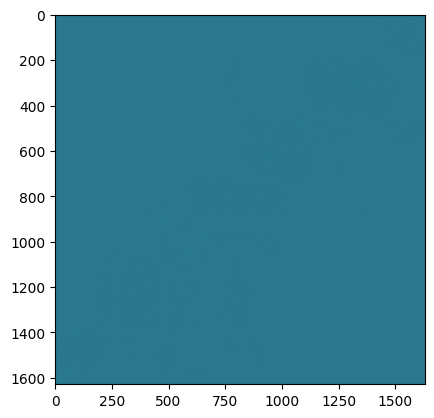

In [113]:
bolzmann_factor.shape

(3080,)

In [127]:
[(slice_[0],slice_[1]) for slice_ in slices]

[(np.int64(0), np.int64(9)),
 (np.int64(9), np.int64(171)),
 (np.int64(171), np.int64(628)),
 (np.int64(628), np.int64(762)),
 (np.int64(762), np.int64(1504)),
 (np.int64(1504), np.int64(1781)),
 (np.int64(1781), np.int64(1871)),
 (np.int64(1871), np.int64(2343)),
 (np.int64(2343), np.int64(2454)),
 (np.int64(2454), np.int64(2616)),
 (np.int64(2616), np.int64(2750)),
 (np.int64(2750), np.int64(2840)),
 (np.int64(2840), np.int64(2878)),
 (np.int64(2878), np.int64(3046)),
 (np.int64(3046), np.int64(3079))]

In [131]:
[(np.linalg.norm(eigenvectors[ slice_], axis=0)).shape for slice_ in slices]

[(3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,),
 (3080,)]

In [129]:
[(bolzmann_factor *np.linalg.norm(eigenvectors[ slice_], axis=0)) for slice_ in slices]

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([6.06698207e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.52246179e-27, 2.38024139e-27])]

In [134]:
np.sum(bolzmann_factor)

np.float64(1.0)

In [173]:
slices, eigenvectors.shape

(array([[   0,    9],
        [   9,  171],
        [ 171,  628],
        [ 628,  762],
        [ 762, 1504],
        [1504, 1781],
        [1781, 1871],
        [1871, 2343],
        [2343, 2454],
        [2454, 2616],
        [2616, 2750],
        [2750, 2840],
        [2840, 2878],
        [2878, 3046],
        [3046, 3079]]),
 (3080, 3080))

In [132]:
[np.sum(bolzmann_factor *np.linalg.norm(eigenvectors[ slice_], axis=0)) for slice_ in slices]

[np.float64(3.0213504205806833e-05),
 np.float64(3.6076329054127865e-16),
 np.float64(4.619601908019634e-11),
 np.float64(4.619601922104547e-11),
 np.float64(1.8474854225094963e-11),
 np.float64(3.506429922488332e-11),
 np.float64(1.6589491965604753e-11),
 np.float64(3.66301876270305e-05),
 np.float64(3.6630187631205766e-05),
 np.float64(1.0874182413881357e-10),
 np.float64(3.919439055621111e-10),
 np.float64(1.721903784306323e-05),
 np.float64(1.722154300556013e-05),
 np.float64(0.024367558859917694),
 np.float64(0.1039766462093011)]

In [142]:
[-np.log10(np.sum(bolzmann_factor *np.linalg.norm(eigenvectors[ slice_], axis=0))) for slice_ in slices]

[np.float64(4.519798901704927),
 np.float64(15.44277766050497),
 np.float64(10.335395447950253),
 np.float64(10.335395446626112),
 np.float64(10.733418979698312),
 np.float64(10.45513483624067),
 np.float64(10.780166913548443),
 np.float64(4.436160856787945),
 np.float64(4.436160856738442),
 np.float64(9.963603386004381),
 np.float64(9.406776084122525),
 np.float64(4.76399111949808),
 np.float64(4.763927939480566),
 np.float64(1.6131879762223165),
 np.float64(0.9830641949451797)]

In [133]:
np.sum([np.sum(bolzmann_factor *np.linalg.norm(eigenvectors[ slice_], axis=0)) for slice_ in slices])

np.float64(0.12848212019273822)

In [141]:
[-np.log10(np.sum(bolzmann_factor *np.linalg.norm(eigenvectors[ slice_], axis=0))) for slice_ in slices]

[np.float64(4.519798901704927),
 np.float64(15.44277766050497),
 np.float64(10.335395447950253),
 np.float64(10.335395446626112),
 np.float64(10.733418979698312),
 np.float64(10.45513483624067),
 np.float64(10.780166913548443),
 np.float64(4.436160856787945),
 np.float64(4.436160856738442),
 np.float64(9.963603386004381),
 np.float64(9.406776084122525),
 np.float64(4.76399111949808),
 np.float64(4.763927939480566),
 np.float64(1.6131879762223165),
 np.float64(0.9830641949451797)]

frozenset({(4, 4), (2, 4), (1, 2), (5, 5), (3, 4), (0, 0), (0, 3), (1, 4), (4, 5), (3, 3), (0, 5), (2, 2), (2, 5), (1, 3), (3, 5)})
22 25


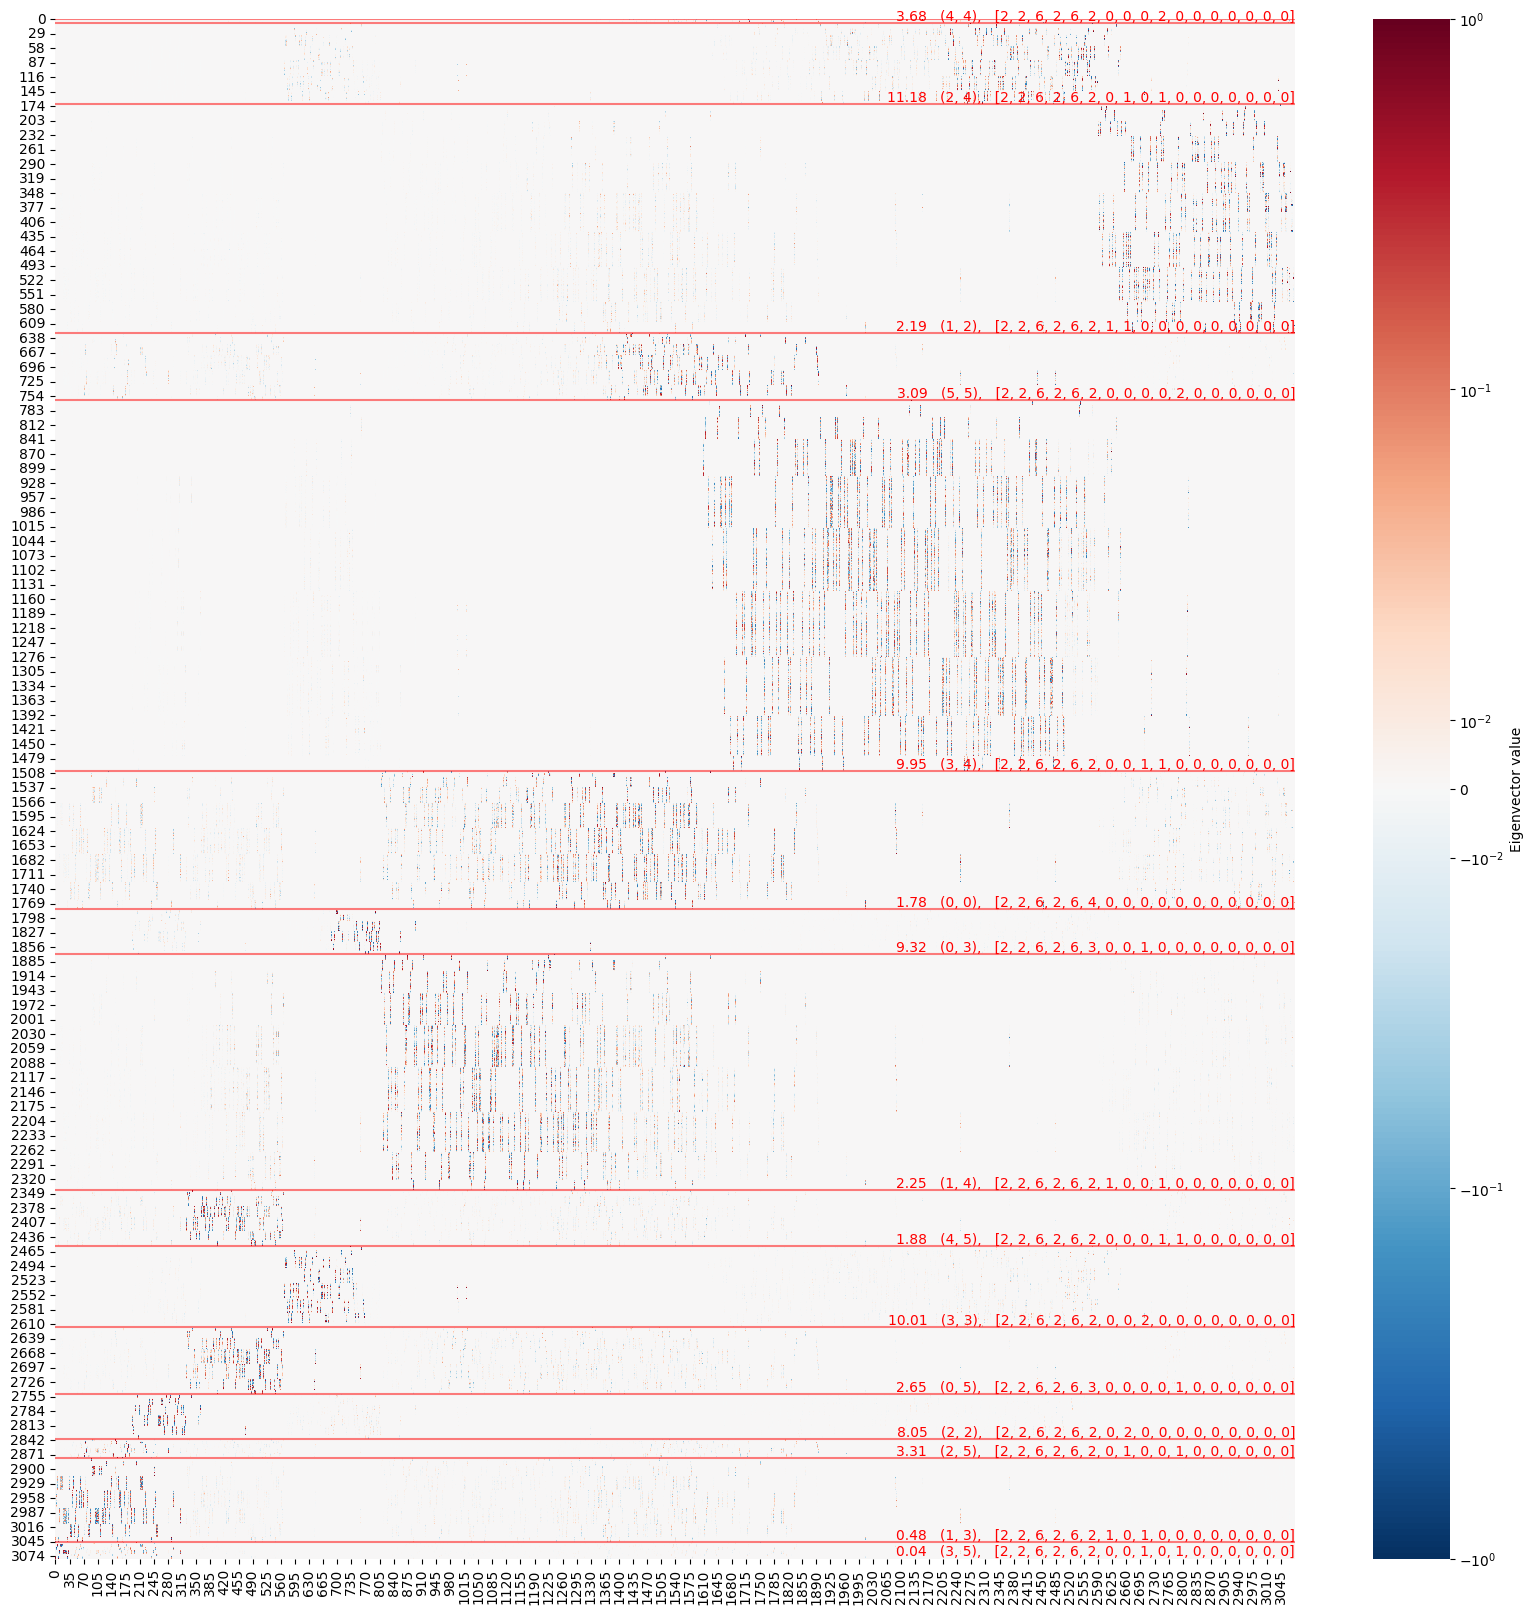

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(20, 20))
#set origin to lower left instead of upper left

# Define the normalization to ensure 0 maps to white
norm = SymLogNorm(linthresh=0.03, linscale=0.5, vmin=-1, vmax=1, base=10)

# Adjust the colormap to have white at 0
cmap = sns.color_palette("RdBu_r", as_cmap=True)

# Create the heatmap
ax = sns.heatmap(
    eigenvectors, 
    cmap=cmap, 
    norm=norm, 
    center=0, 
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Eigenvector value'}
)


print(excitations)

effect = [-np.log10(np.sum(bolzmann_factor *np.linalg.norm(eigenvectors[a:b], axis=0))) for a,b in slices]

excitations_label = [ f'{effect[i]:.2f}'+ '   ' + str(excitation)+',   '+str(asf.to_filling_number(excitation)) for i, excitation in enumerate(excitations)]
print(asf.num_electrons, asf.num_protons)
# Add rectangular patches to highlight slices
for (start, end), label in zip(slices, excitations_label):
    plt.axhline(y=start, color='r', alpha=0.5, label=label)
    ax.text(
        x=ax.get_xlim()[1] - 0.5,  # Position the text at the right of the heatmap
        y=end,  # Align with the horizontal line
        s=label,  # Set the label text
        color='r',  # Color of the text
        fontsize=10,  # Font size
        verticalalignment='bottom',  # Align text vertically
        horizontalalignment='right'  # Align text horizontally
    )
    # Flip the y-coordinate since the heatmap origin is at the bottom left
    # rect = patches.Rectangle(
    #     (start-slices, start),  # (x, y) coordinates of the bottom left corner
    #     end - start,                           # width of the rectangle
    #     end - start,                           # height of the rectangle
    #     linewidth=1.5,                         # thickness of the border
    #     edgecolor='red',                       # color of the border
    #     facecolor='none'                       # no fill inside the rectangle
    # ) 
    # plt.axhline(y=start, color='r', alpha=0.5,label= e)
    # plt.axvline(x=start, color='k', alpha=0.2)
    # ax.add_patch(rect)

In [195]:
effect

[np.float64(9.3197243459526), np.float64(-9.888583168199287e-10)]

In [152]:
effect_list = []
slice_len_list = []
asf_len_list = []
for ion_key in data_dict:
    for asf_key in data_dict[ion_key]:
        if data_dict[ion_key][asf_key]["done_effect"] is True:
            effect_list.extend(data_dict[ion_key][asf_key]["effect"])
            slice_len_list.extend([slice_[1]-slice_[0] for slice_ in data_dict[ion_key][asf_key]["slices"]])
            asf_len_list.extend([len(asf_key)]*len(data_dict[ion_key][asf_key]["slices"]))
print(len(effect_list))
print(len(slice_len_list))
print(len(asf_len_list))

651690
651690
651690


In [166]:
np.min(effect_list)

np.float64(-0.15051499783199063)

In [160]:
element_names = {
    1: "Hydrogen", 2: "Helium", 3: "Lithium", 4: "Beryllium", 5: "Boron",
    6: "Carbon", 7: "Nitrogen", 8: "Oxygen", 9: "Fluorine", 10: "Neon",
    11: "Sodium", 12: "Magnesium", 13: "Aluminum", 14: "Silicon", 15: "Phosphorus",
    16: "Sulfur", 17: "Chlorine", 18: "Argon", 19: "Potassium", 20: "Calcium",
    21: "Scandium", 22: "Titanium", 23: "Vanadium", 24: "Chromium", 25: "Manganese",
    26: "Iron", 27: "Cobalt", 28: "Nickel", 29: "Copper", 30: "Zinc",
    31: "Gallium", 32: "Germanium", 33: "Arsenic", 34: "Selenium", 35: "Bromine",
    36: "Krypton", 37: "Rubidium", 38: "Strontium", 39: "Yttrium", 40: "Zirconium",
    41: "Niobium", 42: "Molybdenum", 43: "Technetium", 44: "Ruthenium", 45: "Rhodium",
    46: "Palladium", 47: "Silver", 48: "Cadmium", 49: "Indium", 50: "Tin",
    51: "Antimony", 52: "Tellurium", 53: "Iodine", 54: "Xenon", 55: "Cesium",
    56: "Barium", 57: "Lanthanum", 58: "Cerium", 59: "Praseodymium", 60: "Neodymium",
    61: "Promethium", 62: "Samarium", 63: "Europium", 64: "Gadolinium", 65: "Terbium",
    66: "Dysprosium", 67: "Holmium", 68: "Erbium", 69: "Thulium", 70: "Ytterbium",
    71: "Lutetium", 72: "Hafnium", 73: "Tantalum", 74: "Tungsten", 75: "Rhenium",
    76: "Osmium", 77: "Iridium", 78: "Platinum", 79: "Gold", 80: "Mercury",
    81: "Thallium", 82: "Lead", 83: "Bismuth", 84: "Polonium", 85: "Astatine",
    86: "Radon", 87: "Francium", 88: "Radium", 89: "Actinium", 90: "Thorium",
    91: "Protactinium", 92: "Uranium", 93: "Neptunium", 94: "Plutonium", 95: "Americium",
    96: "Curium", 97: "Berkelium", 98: "Californium", 99: "Einsteinium", 100: "Fermium",
    101: "Mendelevium", 102: "Nobelium", 103: "Lawrencium", 104: "Rutherfordium", 105: "Dubnium",
    106: "Seaborgium", 107: "Bohrium", 108: "Hassium", 109: "Meitnerium", 110: "Darmstadtium",
    111: "Roentgenium", 112: "Copernicium", 113: "Nihonium", 114: "Flerovium", 115: "Moscovium",
    116: "Livermorium", 117: "Tennessine", 118: "Oganesson"
}

In [198]:
rows = []
for ion_key, ion_value in data_dict.items():
    element = element_names[ion_key[0]]
    num_asfs = len(ion_value)
    excitation = ion_key[0]-ion_key[1]
    num_protons = ion_key[0]
    for asf_key, asf_value in ion_value.items():
        # print(asf_key)
        # print(asf_value)
        for i in range(len(asf_key)):
            if not np.isnan(asf_value['effect'][i]):
                rows.append({'ion': ion_key,
                    'num_csfs':len(asf_key), 
                    'converged': np.any(asf_value['converged']==True),
                    'effect': asf_value['effect'][i],
                    'num_protons':num_protons, 
                    'element': element,
                    'slice_len': asf_value['slices'][i][1]-asf_value['slices'][i][0],
                    'slice_percent': (asf_value['slices'][i][1]-asf_value['slices'][i][0])/asf_value['slices'][-1][-1],
                    'max_slice': asf_value['slices'][-1][-1],
                    'excitation': excitation})
                    

# Create the DataFrame from the list of rows
df1 = pd.DataFrame(rows)

# Calculate mean effect for each unique ion
df1['ion_mean_effect'] = df1.groupby('ion')['effect'].transform('mean')

# Calculate mean effect for each unique combination of ion and num_csfs
df1['ion_num_csf_mean_effect'] = df1.groupby(['ion', 'num_csfs'])['effect'].transform('mean')

df1

,ion,num_csfs,converged,effect,num_protons,element,slice_len,slice_percent,max_slice,excitation,ion_mean_effect,ion_num_csf_mean_effect
0,"(16, 13)",14,True,2.489864,16,Sulfur,39,0.160494,243,3,6.033107,7.718696
1,"(16, 13)",14,True,11.614871,16,Sulfur,16,0.065844,243,3,6.033107,7.718696
2,"(16, 13)",14,True,11.168442,16,Sulfur,24,0.098765,243,3,6.033107,7.718696
3,"(16, 13)",14,True,2.185526,16,Sulfur,23,0.094650,243,3,6.033107,7.718696
4,"(16, 13)",14,True,9.525669,16,Sulfur,8,0.032922,243,3,6.033107,7.718696
...,...,...,...,...,...,...,...,...,...,...,...,...
651685,"(38, 37)",3,True,0.237143,38,Strontium,1,0.200000,5,1,0.367985,0.532753
651686,"(38, 37)",3,True,0.736276,38,Strontium,2,0.400000,5,1,0.367985,0.532753
651687,"(38, 37)",1,True,-0.000000,38,Strontium,2,1.000000,2,1,0.367985,0.000000
651688,"(38, 37)",2,True,0.248688,38,Strontium,2,0.500000,4,1,0.367985,0.336406


In [205]:
# get all the rows where num_csfs is 1
df1[df1['num_csfs']==1]

,ion,num_csfs,converged,effect,num_protons,element,slice_len,slice_percent,max_slice,excitation,ion_mean_effect,ion_num_csf_mean_effect
8345,"(16, 13)",1,True,-0.000000e+00,16,Sulfur,2,1.0,2,3,6.033107,0.000000e+00
15452,"(15, 14)",1,True,3.565803e-11,15,Phosphorus,5,1.0,5,1,3.236070,3.565803e-11
20385,"(25, 22)",1,True,-3.228571e-10,25,Manganese,34,1.0,34,3,4.383817,-3.228571e-10
38082,"(14, 11)",1,True,-0.000000e+00,14,Silicon,1,1.0,1,3,3.608862,0.000000e+00
44434,"(7, 7)",1,True,-2.215846e-10,7,Nitrogen,5,1.0,5,0,2.381947,-2.215846e-10
...,...,...,...,...,...,...,...,...,...,...,...,...
649519,"(8, 5)",1,True,-0.000000e+00,8,Oxygen,2,1.0,2,3,9.294466,0.000000e+00
650795,"(46, 44)",1,True,6.925472e-10,46,Palladium,9,1.0,9,2,1.957040,6.925472e-10
651168,"(28, 27)",1,True,-0.000000e+00,28,Nickel,2,1.0,2,1,1.691827,0.000000e+00
651679,"(41, 41)",1,True,4.552267e-10,41,Niobium,37,1.0,37,0,0.640923,4.552267e-10


In [200]:
# get all the rows where effect is negative
df1[df1['effect']<0]

,ion,num_csfs,converged,effect,num_protons,element,slice_len,slice_percent,max_slice,excitation,ion_mean_effect,ion_num_csf_mean_effect
20385,"(25, 22)",1,True,-3.228571e-10,25,Manganese,34,1.000000,34,3,4.383817,-3.228571e-10
20472,"(25, 22)",3,True,-5.020562e-10,25,Manganese,34,0.066667,510,3,4.383817,4.962832e+00
23036,"(25, 22)",2,True,-2.564170e-10,25,Manganese,34,0.274194,124,3,4.383817,4.280706e+00
27843,"(25, 22)",2,True,-8.672693e-10,25,Manganese,34,0.274194,124,3,4.383817,4.280706e+00
27888,"(25, 22)",2,True,-1.651161e-10,25,Manganese,34,0.173469,196,3,4.383817,4.280706e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
644395,"(45, 43)",1,True,-7.989386e-11,45,Rhodium,19,1.000000,19,2,1.570452,-7.989386e-11
644942,"(42, 42)",1,True,-1.603627e-10,42,Molybdenum,34,1.000000,34,0,0.676616,-1.603627e-10
646049,"(9, 8)",2,True,-3.170191e-10,9,Fluorine,5,0.106383,47,1,4.927110,3.789156e+00
646055,"(9, 8)",2,True,-6.402983e-10,9,Fluorine,5,0.106383,47,1,4.927110,3.789156e+00


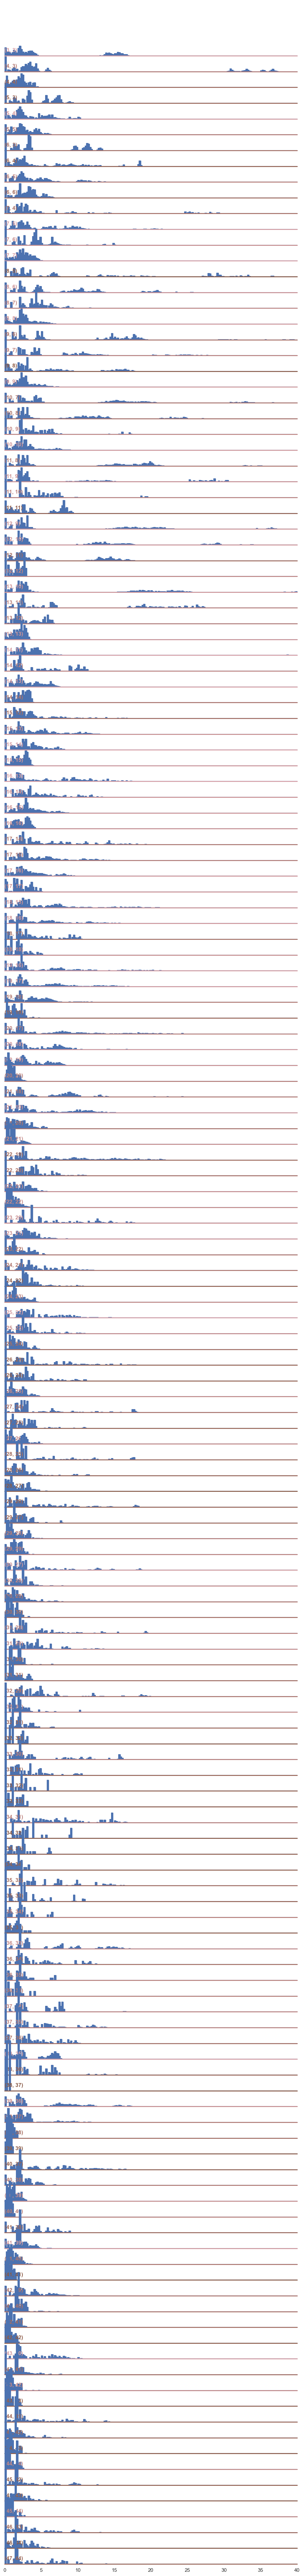

In [203]:
sorted_ions = sorted(df1['ion'].unique(), key=lambda x: (x[0], x[1]))

# Set the theme
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create a palette
pal = sns.cubehelix_palette(len(sorted_ions), start=1.4, rot=-.25, light=.7, dark=.4)

# Create the FacetGrid with sorted 'ion' values
g = sns.FacetGrid(df1, row="ion", hue="ion", aspect=20, height=.5, palette=pal, row_order=sorted_ions)

# Add the plots
g.map_dataframe(sns.histplot, x="effect", hue="converged", element="step", bins=200, binrange=(0,40), stat= 'probability', alpha=1, linewidth=1.5)
g.map_dataframe(sns.histplot, x="effect", hue="converged", element="step", bins=200, binrange=(0,40), stat= 'probability', color="w", lw=2)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Function to label the plots
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "ion")

# Remove default titles
g.set_titles("")

# Adjust the layout
g.fig.subplots_adjust(hspace=-.7)
g.set(yticks=[], xlabel="", ylabel="", xlim=(0, 40))
g.despine(bottom=True, left=True)

# Show the plot
plt.show()

In [174]:
10**0.150515, np.sqrt(2)

(1.4142135694328861, np.float64(1.4142135623730951))

In [1]:
effect_list

NameError: name 'effect_list' is not defined

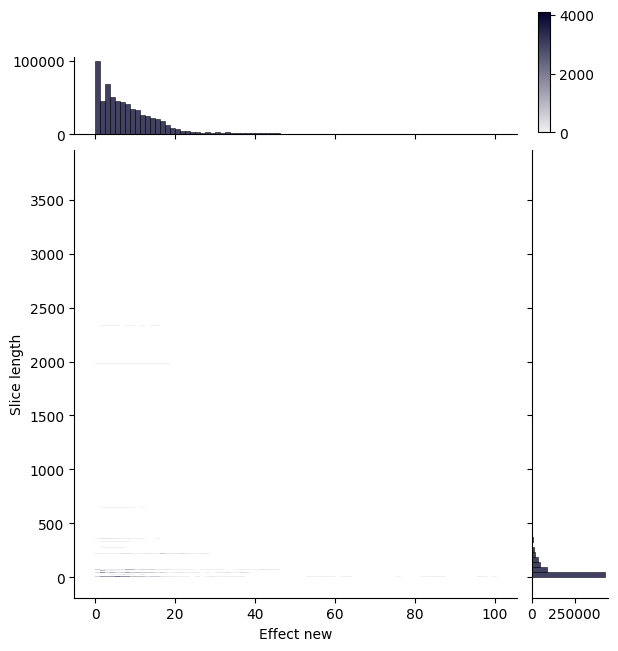

In [202]:
# Create the JointGrid for runtime vs last slice value
g = sns.JointGrid(x=effect_list, y=slice_len_list, marginal_ticks=True)

# Create an inset legend for the histogram colorbar in the top right
cax = g.figure.add_axes([.85, .84, .02, .2])

# Create the joint and marginal histogram plots with discrete settings
n_bins = 80

g.plot_joint(
    sns.histplot, discrete=(False, True),bins = n_bins, cmap="light:#03012d", 
    pmax=.8, cbar=True, cbar_ax=cax, log_scale=(False, False)

)
g.plot_marginals(sns.histplot, element="bars", color="#03012d",bins=n_bins, discrete=False, log_scale=False)



# Adding a figure-level title in the correct format
# plt.suptitle(f'Runtime vs Last Slice Value in Slices', y=1.02)


# # Adding the correct labels to the joint plot axes
g.ax_joint.set_xlabel('Effect new')
g.ax_joint.set_ylabel('Slice length')

# Display the plot with adjusted layout
plt.show()


In [89]:
[str(excitation) for excitation in excitations]

['(4, 4)',
 '(2, 4)',
 '(1, 2)',
 '(5, 5)',
 '(3, 4)',
 '(0, 0)',
 '(0, 3)',
 '(1, 4)',
 '(4, 5)',
 '(3, 3)',
 '(0, 5)',
 '(2, 2)',
 '(2, 5)',
 '(1, 3)',
 '(3, 5)']

In [79]:
np.max(eigenvectors), np.min(eigenvectors)

(np.float64(0.99352744), np.float64(-0.67013329))

In [85]:
asf.excitations

frozenset({(0, 0),
           (0, 3),
           (0, 5),
           (1, 2),
           (1, 3),
           (1, 4),
           (2, 2),
           (2, 4),
           (2, 5),
           (3, 3),
           (3, 4),
           (3, 5),
           (4, 4),
           (4, 5),
           (5, 5)})

In [29]:
# Assume eigenvectors and slices are defined as before
matrix_size = eigenvectors.shape[1]

Ediff = eigenvalues - eigenvalues[0]  # ["Ryd."]
bolzmann_factor = np.exp(-Ediff * ryd_to_kelvin / temp_kelvin)
bolzmann_factor /= bolzmann_factor.sum()

log_boltz_inside = []
log_boltz_outside = []


for start, end in slices:
    # Adjust end to ensure it's within bounds
    end = min(end, matrix_size)  # or matrix_size - 1 if it's needed as an exclusive upper bound

    slice_ = slice(start, end)

    inside_slice = eigenvectors[slice_]

    outside_slice = np.delete(eigenvectors, slice_, axis=0)

    norm_inside = np.linalg.norm(inside_slice, axis=0)
    norm_outside = np.linalg.norm(outside_slice, axis=0)


    log_boltz_inside.append(np.log10(np.sum(bolzmann_factor*norm_inside)))
    log_boltz_outside.append(np.log10(1-np.sum(bolzmann_factor*norm_outside)))
    print(np.log10(np.sum(bolzmann_factor*norm_inside)))
    print(np.log10(1-np.sum(bolzmann_factor*norm_outside)))
    print()
    # print(slice_)
    # print(np.mean(np.linalg.norm(inside_slice, axis=0)))
    # print(np.mean(np.linalg.norm(outside_slice, axis=0)))


-2.969426691576425
-6.237170327258964

-7.557071194892636
-8.440116876694606

-1.838707302125009
-3.978401189139035

-4.547475958965883
-8.397822244322763

-6.766254116578544
-8.322559622753353

-1.6298849298233467
-3.5607287437767985

-7.352427714162866
-8.432188368318595

-2.1659250940184096
-4.632802293965711

-6.703827440152744
-8.065254636702038

-2.1939889413651232
-4.6889213427983245

-6.446606675492326
-8.06184751068987

-5.653400168299922
-6.709804993403976

-1.911126924589892
-4.123241006887871

-5.796167290486706
-6.929739857171908

-6.0024772378969695
-6.11974642575942

-4.921390781653074
-5.019145071512207

-0.00022281108020322376
-0.013955920966182448



In [27]:
np.sum(eigenvectors**2,axis=0)

array([0.99999999, 1.        , 0.99999999, ..., 1.00000001, 1.        ,
       0.99999999])

In [24]:
np.log10(np.sum(bolzmann_factor*norm_inside))

np.float64(-0.00022281108020322376)

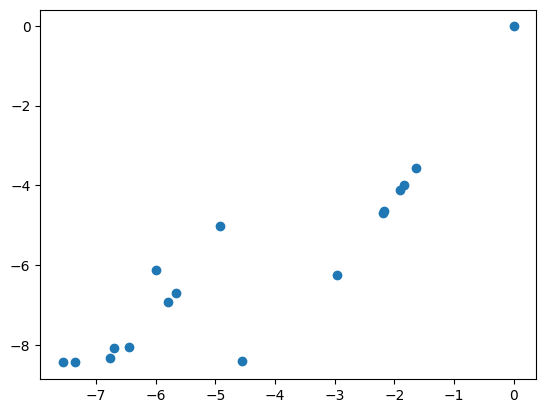

In [30]:
plt.scatter(log_boltz_inside,log_boltz_outside)

In [60]:
Ediff*13.6

array([ 0.        ,  0.12280164, 32.22334494, 32.22359304, 40.4630531 ,
       40.46692873, 40.47373657, 40.4856255 , 40.76703426, 40.83821103,
       40.83918859, 40.87403675, 40.97687627, 41.0059094 , 41.03881701,
       41.07737104, 41.3591681 , 41.39091684, 41.41873792, 41.43603173,
       41.48955263, 41.53418138, 43.32343276, 43.32514875, 43.32742709,
       43.33014528, 44.1821434 , 44.18253553, 44.18318708, 45.39152029,
       45.39834811, 46.0450209 , 46.07234436, 46.36982125, 46.37071974,
       47.9382913 , 47.93916077, 47.97672338, 48.45102197, 48.4530999 ,
       48.72885098, 48.73193518, 48.84911697, 48.86298538, 57.53659281,
       57.53699688, 57.53766919, 57.53860804, 57.73398747, 57.73499774,
       57.73629572, 57.73788072, 57.8458655 , 57.93628644, 57.9367703 ,
       58.06989542, 58.30256348, 58.30272697, 58.56866116, 58.5692519 ,
       58.57007823, 58.57113947, 59.01326732, 59.01450338, 59.25479039,
       59.2573625 , 59.31079308, 59.31108246, 59.31156253, 59.35

In [54]:
ryd_to_kelvin = 11606 * 13.605703976
temp_kelvin = 5000
Ediff = eigenvalues - eigenvalues[0]  # ["Ryd."]
bolzmann_factor = np.exp(-Ediff * ryd_to_kelvin / temp_kelvin)
bolzmann_factor /= bolzmann_factor.sum()

bolzmann_factor

array([5.70812453e-01, 4.29187547e-01, 1.81559762e-33, 1.81455188e-33,
       8.89641415e-42, 8.81670677e-42, 8.67841940e-42, 8.44210150e-42,
       4.39185330e-42, 3.72276431e-42, 3.71432298e-42, 3.42558736e-42,
       2.69786771e-42, 2.52197358e-42, 2.33643110e-42, 2.13634288e-42,
       1.11039271e-42, 1.03147279e-42, 9.66941101e-43, 9.28878870e-43,
       8.20319191e-43, 7.39561789e-43, 1.16011661e-44, 1.15550295e-44,
       1.14940567e-44, 1.14217335e-44, 1.57937706e-45, 1.57793954e-45,
       1.57555392e-45, 9.52402637e-47, 9.37421005e-47, 2.08814448e-47,
       1.95976790e-47, 9.82193539e-48, 9.80146376e-48, 2.57266836e-49,
       2.56747925e-49, 2.35301547e-49, 7.82152171e-50, 7.78387136e-50,
       4.10297354e-50, 4.07369282e-50, 3.10319882e-50, 3.00485290e-50,
       5.37561410e-59, 5.37057243e-59, 5.36219427e-59, 5.35051649e-59,
       3.39902344e-59, 3.39105863e-59, 3.38085285e-59, 3.36843203e-59,
       2.62134609e-59, 2.12487897e-59, 2.12249278e-59, 1.55807581e-59,
      

In [46]:
for slice_ in slices:
    print(slice_)
    print(slice(*slice_))


[0 1]
slice(np.int64(0), np.int64(1), None)
[1 5]
slice(np.int64(1), np.int64(5), None)
[ 5 18]
slice(np.int64(5), np.int64(18), None)
[18 22]
slice(np.int64(18), np.int64(22), None)
[22 42]
slice(np.int64(22), np.int64(42), None)
[42 51]
slice(np.int64(42), np.int64(51), None)
[51 55]
slice(np.int64(51), np.int64(55), None)
[55 67]
slice(np.int64(55), np.int64(67), None)
[67 79]
slice(np.int64(67), np.int64(79), None)
[79 83]
slice(np.int64(79), np.int64(83), None)
[ 83 103]
slice(np.int64(83), np.int64(103), None)
[103 112]
slice(np.int64(103), np.int64(112), None)


<Axes: ylabel='Count'>

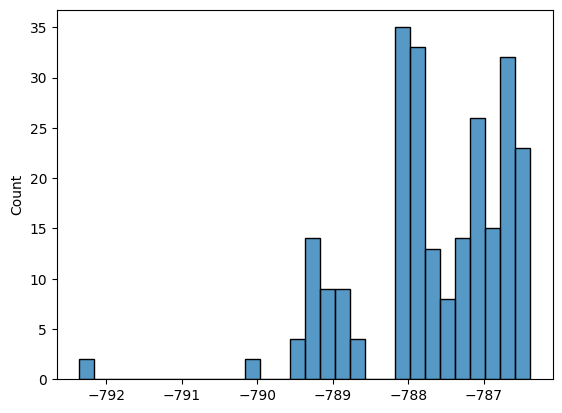

In [29]:
sns.histplot(eigenvalues, bins=30, )

In [7]:
ion_keys_sorted[-80:-70]

[(26, 23),
 (26, 24),
 (26, 25),
 (26, 26),
 (27, 24),
 (27, 25),
 (27, 26),
 (27, 27),
 (28, 25),
 (28, 26)]

In [ ]:
[(27, 27),(27, 25),(26, 26),(26, 23),(26, 24)]

In [5]:
ion_keys_sorted[-87:-84]+ion_keys_sorted[-83:-80]

[(24, 22), (24, 23), (24, 24), (25, 23), (25, 24), (25, 25)]

In [8]:
# (19, 17)
create_data_dict([(27, 27),(27, 25),(26, 26),(26, 23),(26, 24)],run_checks=True)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
closing from __exit__


Processing ion: (27, 27) (5/5): 100%|██████████| 1473/1473 [11:29:43<00:00, 28.09s/ASF]    


In [44]:
[ion_keys_sorted[-87:-70]]

[[(24, 22),
  (24, 23),
  (24, 24),
  (25, 22),
  (25, 23),
  (25, 24),
  (25, 25),
  (26, 23),
  (26, 24),
  (26, 25),
  (26, 26),
  (27, 24),
  (27, 25),
  (27, 26),
  (27, 27),
  (28, 25),
  (28, 26)]]

In [23]:
[ion_keys_sorted[-38:-28]]

[[(36, 35),
  (36, 36),
  (37, 34),
  (37, 35),
  (37, 36),
  (38, 35),
  (38, 36),
  (38, 37),
  (39, 36),
  (39, 37)]]

In [38]:
[ion_keys_sorted[-60]]

[(31, 28)]

In [39]:
create_data_dict(ion_keys_sorted[-70:-60],run_checks=True)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
closing from __exit__


Processing ion: (28, 28) (10/10): 100%|██████████| 8174/8174 [3:16:03<00:00,  1.44s/ASF]  


In [17]:
create_data_dict(ion_keys_sorted[-24:-22],run_checks=True)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
closing from __exit__


Processing ion: (40, 40) (2/2): 100%|██████████| 1482/1482 [00:21<00:00, 69.31ASF/s] 


In [19]:
create_data_dict(ion_keys_sorted[30:50],run_checks=True)

/Users/moustholmes/Projects/METAL-AI/data/Li-Rh/results/master.hdf5
closing from __exit__
Processing ion: (16, 13) (1/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Processing ion: (15, 14) (2/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing ion: (14, 11) (3/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Processing ion: (14, 13) (4/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Processing ion: (15, 15) (5/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing ion: (12, 10) (6/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing ion: (13, 10) (7/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing ion: (12, 9) (8/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing ion: (13, 13) (9/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Processing ion: (16, 15) (10/20)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Processing

In [67]:
dict_test = {}
dict_test[1] =( (1),(2))
print(dict_test)

{1: (1, 2)}


In [136]:
slices = np.array([[ 0 , 1],[ 1 , 5],[ 5 , 9],[ 9 ,13],[13,22]])
g = np.array([[ 0 , 1],[ 1 , 5],[ 9 ,13],[13,22]])
# i = 4
# # print(slices[:i])
# # print(slices[i + 1:])
# print(np.delete(slices, i, axis=0))
for i in range(len(slices)):
    print(i)
    print(np.delete(slices, i, axis=0))
    print()
    if not (np.delete(slices, i, axis=0) == g).all():
        print("yes")
# print(np.stack(slices[:i] + slices[i + 1:]))

0
[[ 1  5]
 [ 5  9]
 [ 9 13]
 [13 22]]
yes
1
[[ 0  1]
 [ 5  9]
 [ 9 13]
 [13 22]]
yes
2
[[ 0  1]
 [ 1  5]
 [ 9 13]
 [13 22]]
3
[[ 0  1]
 [ 1  5]
 [ 5  9]
 [13 22]]
yes
4
[[ 0  1]
 [ 1  5]
 [ 5  9]
 [ 9 13]]
yes


In [ ]:
def explore_selected_groups(file_handle, num_groups=3):
    """
    Explore a few groups (worker files) and their contents, handling scalar datasets properly.
    
    Parameters:
    - file_handle: The HDF5 file handle
    - num_groups: Number of groups (worker files) to explore
    """
    group_count = 0
    
    for key in file_handle.keys():
        if group_count >= num_groups:
            break

        group = file_handle[key]
        
        if isinstance(group, h5py.Group):
            print(f"\nExploring group: {key}")
            print(f"Contains {len(group.keys())} items")

            # Explore sub-items in the group
            for sub_key, item in group.items():
                if isinstance(item, h5py.Group):
                    print(f"  {sub_key} is a sub-group with {len(item)} items")
                elif isinstance(item, h5py.Dataset):
                    print(f"  {sub_key} is a dataset - shape: {item.shape}, dtype: {item.dtype}")
                    
                    # Handle scalar datasets
                    if item.shape == ():  # This means it's a scalar dataset
                        print(f"    Scalar value: {item[()]}")
                    else:
                        # Print a small sample of the dataset for non-scalar datasets
                        print(f"    Data sample: {item[()][:10] if len(item) >= 10 else item[()]}")
        
        group_count += 1



# Explore only a few groups (e.g., the first 3 worker groups)
with hdf5_funcs.ResultsLoader() as loader:
    explore_selected_groups(loader.file_handle, num_groups=3)

def recursive_explore_group(group, level=0):
    """
    Recursively explores the contents of a group, including sub-groups.
    
    Parameters:
    - group: The HDF5 group to explore
    - level: Current recursion depth for formatting output
    """
    indent = "  " * level
    
    for sub_key, item in group.items():
        if isinstance(item, h5py.Group):
            print(f"{indent}{sub_key} is a sub-group with {len(item)} items")
            recursive_explore_group(item, level + 1)
        elif isinstance(item, h5py.Dataset):
            print(f"{indent}{sub_key} is a dataset - shape: {item.shape}, dtype: {item.dtype}")
            # Handle scalar datasets
            if item.shape == ():  # This means it's a scalar dataset
                print(f"    Scalar value: {item[()]}")
            else:
                # Print a small sample of the dataset for non-scalar datasets
                print(f"    Data sample: {item[()][:10] if len(item) >= 10 else item[()]}")

def explore_selected_groups_recursive(file_handle, num_groups=3):
    """
    Explore a few groups (worker files) and their contents recursively.
    
    Parameters:
    - file_handle: The HDF5 file handle
    - num_groups: Number of groups (worker files) to explore
    """
    group_count = 0
    
    for key in file_handle.keys():
        if group_count >= num_groups:
            break

        group = file_handle[key]
        
        if isinstance(group, h5py.Group):
            print(f"\nExploring group: {key}")
            recursive_explore_group(group)

        group_count += 1

# Explore a few groups recursively
with hdf5_funcs.ResultsLoader() as loader:
    explore_selected_groups_recursive(loader.file_handle, num_groups=3)

In [95]:
a= 0
b= 0.2

print(not ( a==1 or np.isnan(b)))  
print(not np.isnan(a) and np.isnan(b))

True
False


checks on dataset 
1. All indicies that are not nan for both effect corrosponds to a ASF in the dict 
2. All indicies where converged is true effect is not nan 
3. All posible previous ASF when removing the correspons slices indicies you get previous slices 

In [38]:
list1 = [1,2,3,4,5,6]
# i_test = 5
# print(list1[:i_test] + list1[i_test+1:])
for i in range(len(list1)):
    print(i)
    print(list1[:i] + list1[i+1:])

0
[2, 3, 4, 5, 6]
1
[1, 3, 4, 5, 6]
2
[1, 2, 4, 5, 6]
3
[1, 2, 3, 5, 6]
4
[1, 2, 3, 4, 6]
5
[1, 2, 3, 4, 5]


In [95]:
sorted(
    (
        (2, 2, 6, 2, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0), 
        (2, 2, 6, 2, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        )
    )

[(2, 2, 6, 2, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0),
 (2, 2, 6, 2, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)]

In [97]:
sorted(((2),(1),(3),(4),(5),(6)))

[1, 2, 3, 4, 5, 6]

In [98]:
sorted(zip(((2),(1),(3),(4),(5),(6)),('b','a','c','d','e','f')))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e'), (6, 'f')]

In [46]:


def test_data_dict(data_dict):
    # check if there is 
    for ion_key, ion_dict in data_dict.items():
        for asf_key, asf_dict in ion_dict.items():
            for i in range(len(asf_key)):
                if asf_dict['converged'][i] == 1:
                    # print("effect")
                    # print(asf_dict['effect'])
                    # print("converged")
                    # print(asf_dict['converged'])
                    print(asf_dict['effect'][i])
                    # print(ion_key, asf_key, i)
                    
            


In [47]:
data_dict_path = "/Users/moustholmes/Projects/METAL-AI/data/ion_dicts_new/data_dict_20_20.pkl"
# Use 'rb' to read in binary mode
with open(data_dict_path, 'rb') as file:
    data_dict = pickle.load(file)

test_data_dict(data_dict)

nan
nan
4.141332894866275
nan
0.008894751931848518
nan
nan
0.0029387871790732926
0.051881212135766366
nan
nan
nan
nan
nan
nan
nan
0.07323485037066108
0.04350937971722408
1.1087753329343741
nan
nan
1.5570195811415428
0.28103099599041254
0.6860692883062834
2.3708625229189133
nan
nan
nan
nan
nan
0.7991946485424433
nan
0.35981954115866444
nan
nan
nan
nan
nan
nan
nan
nan
0.42212851430158516
0.18121533405299622
